In [7]:
import numpy as np
import pandas as pd
%matplotlib inline
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.distributions.mixture_rvs import mixture_rvs

In [8]:
# import the csv file
df = pd.read_csv('./prepared_data/2020_ffl_df.csv')

# clean up the kde_icdf column
for i in range(0,len(df)):
    df['kde_icdf'][i] = df['kde_icdf'][i].replace('\n',' ').replace('[','').replace(']','')
    df['kde_icdf'][i] = [float(x) for x in df['kde_icdf'][i].split()]
    
# more data cleanup
df['POS']=df['POS'].str.strip()

# add drafted column to track drafted players
df['drafted']=0

In [ ]:
def get_current_draft_number():
    current_draft_number = 0
    i = 0
    while current_draft_number == 0:
        if df['drafted'][i] == 1:
            i += 1
        else:
            current_draft_number = df['Draft Position'][i]

In [ ]:
def 

In [9]:
def DAsHa_prgm(turns_to_next_pick):
    # variable for 'turns to next pick'
    # ttnp = 24

    # to find current draft number
    # current_draft_number = 0
    # i = 0
    # while current_draft_number == 0:
    #     if df['drafted'][i] == 1:
    #         i += 1
    #     else:
    #         current_draft_number = df['Draft Position'][i]
    current_draft_number = get_current_draft_number()

    # threshold for next available picks
    next_available_pick = current_draft_number + turns_to_next_pick

    # loops to construct information panes to visualize later
    compare1 = [] # to collect best players at each position
    compare2 = [] # to collect best available next round at each position (note: may overlap with compare1)
    compare3 = [] # to collect second-best player at each position

    positions = ['QB','RB','WR','TE','K','DEF']

    # loop to identify best choices
    j = 0
    for j in range(0, len(positions)):
        k = 0
        for k in range(0, len(df)):
            if df['drafted'][k] == 1:
                k += 1
            if df['drafted'][k] == 0:
                if df['POS'][k] == positions[j]:
                    if len(compare1) > j:
                        if df['pts'][k] > compare1[j][2]:
                            compare1[j] = [df['POS'][k], df['Name'][k], df['pts'][k], df['Draft Position'][k]]
                            k += 1
                        if df['pts'][k] <= compare1[j][2]:
                            k += 1
                    if len(compare1)<=j:
                        compare1.append([df['POS'][k], df['Name'][k], df['pts'][k],df['Draft Position'][k]])
                        k += 1

    # loop to identify best choice in next round at each position                
    j = 0
    for j in range(0, len(positions)):
        k = 0
        for k in range(0, len(df)):
            if df['drafted'][k] == 1:
                k += 1
            if df['drafted'][k] == 0:
                if df['POS'][k] == positions[j]:
                    if len(compare2) > j:
                        if df['Draft Position'][k] < next_available_pick:
                            k += 1
                        else:
                            if df['pts'][k] > compare2[j][2]:
                                compare2[j] = [df['POS'][k], df['Name'][k], df['pts'][k], df['Draft Position'][k]]
                                k += 1
                            if df['pts'][k] <= compare2[j][2]:
                                k += 1
                    if len(compare2) <= j:
                        if df['Draft Position'][k] < next_available_pick:
                            k += 1
                        else:
                            compare2.append([df['POS'][k], df['Name'][k], df['pts'][k], df['Draft Position'][k]])
                            k += 1 

    # loop to collect second-best choices for each round
    j = 0
    for j in range(0,len(positions)):
        k = 0
        for k in range(0,len(df)):
            if df['drafted'][k] == 1:
                k += 1
            if df['drafted'][k] == 0:
                if df['POS'][k] == positions[j]:
                    if len(compare3) > j:
                        if df['Name'][k] == compare1[j][1]:
                            k += 1
                        else:
                            if df['pts'][k] > compare3[j][2]:
                                compare3[j]=[df['POS'][k], df['Name'][k], df['pts'][k], df['Draft Position'][k]]
                                k += 1
                            if df['pts'][k] <= compare3[j][2]:
                                k += 1
                    if len(compare3) <= j:
                        if df['Name'][k] == compare1[j][1]:
                            k += 1
                        else:
                            compare3.append([df['POS'][k], df['Name'][k], df['pts'][k], df['Draft Position'][k]])
                            k += 1 

    # make marginal comparison and append to compare1 list
    for j in range(0,len(positions)):
        marg = compare1[j][2] - compare2[j][2]
        compare1[j].append(marg)

    # print recommendation menu
    for i in range(0,len(positions)):
        print(f"{compare1[i][0]:{5}} - {compare1[i][1]:{20}} - {round(compare1[i][2],2):{6}}, margin: {round(compare1[i][4],2)}")

    # find top two second-best
    top_seconds = [compare3[0][2], compare3[1][2], compare3[2][2], compare3[3][2], compare3[4][2], compare3[5][2],]

    # finding index values (based off Yahoo! draft position) to call the boxplots
    DEF = compare1[0][3] - 1
    K = compare1[1][3] - 1
    TE = compare1[2][3] - 1
    WR = compare1[3][3] - 1
    RB = compare1[4][3] - 1
    QB = compare1[5][3] - 1

    # boxplots of recs
    box_plot_data=[df['kde_icdf'][QB], df['kde_icdf'][RB], df['kde_icdf'][WR], df['kde_icdf'][TE], df['kde_icdf'][K], df['kde_icdf'][DEF]]
    plt.boxplot(box_plot_data, vert=False, labels=[df['Name'][QB], df['Name'][RB], df['Name'][WR], df['Name'][TE], df['Name'][K], df['Name'][DEF] ])
    plt.show()

    # find top two second-best
    top_seconds = [compare3[0][2], compare3[1][2], compare3[2][2], compare3[3][2],compare3[4][2],compare3[5][2],]
    first_comp = top_seconds.index(max(top_seconds))
    top_seconds[first_comp] = 0
    second_comp = top_seconds.index(max(top_seconds))

    # boxplots of second best
    z = compare1[first_comp][3] - 1
    y = compare3[first_comp][3] - 1
    x = compare1[second_comp][3] - 1
    w = compare3[second_comp][3] - 1

    box_plot_data=[df['kde_icdf'][y], df['kde_icdf'][z]]
    plt.boxplot(box_plot_data, vert=False, labels=[df['Name'][y], df['Name'][z]])
    plt.show()

    box_plot_data=[df['kde_icdf'][w], df['kde_icdf'][x]]
    plt.boxplot(box_plot_data, vert=False, labels=[df['Name'][w], df['Name'][x]])
    plt.show()

In [10]:
### This is the user-interace: enter the picked players until it's your turn. Then, enter "DAsHA_prgm(# of rounds to your next pick)" in the cell below.


In [37]:
your_turn = False
while your_turn == False:
    new_draft = input('Who was the last pick?')
    if new_draft != '':
        temp_index = df['Name'].str.find(str(new_draft.strip()))
        temp_no = temp_index.values.argmax()
        df['drafted'][temp_no] = 1
        new_draft = ''
    your_turn_input = input('Is it your turn?')
    no_set = {'no', 'n', 'N', 'No'}   
    if your_turn_input in no_set: 
        your_turn = False
    else:
        your_turn = True


QB    - Dak Prescott         - 346.58, margin: 68.94
RB    - Derrick Henry        - 272.44, margin: 0.0
WR    - Michael Thomas       - 251.89, margin: 0.0
TE    - Zach Ertz            - 150.78, margin: 0.0
K     - Harrison Butker      - 153.07, margin: 0.0
DEF   - San Francisco        - 144.64, margin: 0.0


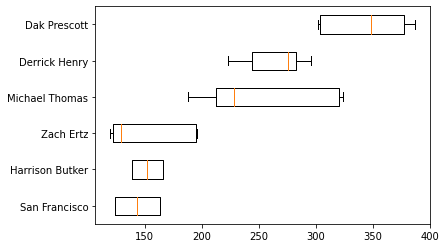

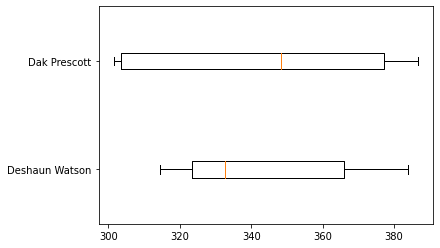

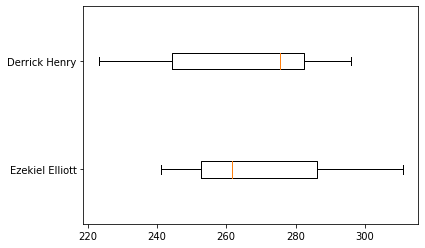

In [38]:
DAsHa_prgm(14)